In [1]:
import matplotlib.pyplot as plt

In [2]:
#%load_ext heat

In [3]:
%%time
#%%heat
import pandas as pd
import re
import datetime
import gzip
from dateutil import tz


# gzip file.cap - some of them were over 800MB
INPUT_FILE="electricity-meter-rtc.cap.gz"
#INPUT_FILE="electricity-meter-rtc-DS3231.cap.gz"

data = []
with gzip.open(INPUT_FILE, "rt") as f:
    rtc_regex = re.compile(r"^\[([^]]+)\] time: (.+)$")
    millis_regex = re.compile(r"^\[([^]]+)\] time_millis: (.+)$")
    while line := f.readline():
        line = line.rstrip()
        if "time" not in line:
            continue
        re_match = re.fullmatch(rtc_regex, line)
        if re_match:
            rpi_time = datetime.datetime.fromisoformat(re_match[1]).replace(tzinfo=tz.tzlocal())
            device_time = datetime.datetime.fromisoformat(re_match[2].replace("Z", "+00:00")).astimezone(tz.tzlocal())
            #print(f"{rpi_time}, {device_time}")
            data.append((rpi_time, device_time, None))
        re_match = re.fullmatch(millis_regex, line)
        if re_match:
            rpi_time = datetime.datetime.fromisoformat(re_match[1]).replace(tzinfo=tz.tzlocal())
            millis_time = datetime.datetime.fromisoformat(re_match[2].replace("Z", "+00:00")).astimezone(tz.tzlocal())
            data.append((rpi_time, None, millis_time))
    
df = pd.DataFrame(data, columns=("rpi_time", "device_time", "millis_time"))
del data
df

CPU times: user 1min 55s, sys: 1.58 s, total: 1min 56s
Wall time: 1min 58s


,rpi_time,device_time,millis_time
0,2023-10-08 19:24:32.156000+02:00,2023-10-08 19:24:21+02:00,NaT
1,2023-10-08 19:24:32.156000+02:00,NaT,2023-10-08 19:24:21+02:00
2,2023-10-08 19:24:32.162000+02:00,2023-10-08 19:24:22+02:00,NaT
3,2023-10-08 19:24:32.162000+02:00,NaT,2023-10-08 19:24:22+02:00
4,2023-10-08 19:24:32.168000+02:00,2023-10-08 19:24:23+02:00,NaT
...,...,...,...
1395579,2023-10-16 21:13:32.888000+02:00,NaT,2023-10-16 21:14:15+02:00
1395580,2023-10-16 21:13:33.859000+02:00,2023-10-16 21:13:04+02:00,NaT
1395581,2023-10-16 21:13:33.875000+02:00,NaT,2023-10-16 21:14:16+02:00
1395582,2023-10-16 21:13:34.847000+02:00,2023-10-16 21:13:05+02:00,NaT


In [4]:
df["diff"] = (df["device_time"] - df["rpi_time"]).dt.total_seconds()
if not  all(df["millis_time"].isna()):
    df["diff millis"] = (df["millis_time"] - df["rpi_time"]).dt.total_seconds()
df

,rpi_time,device_time,millis_time,diff,diff millis
0,2023-10-08 19:24:32.156000+02:00,2023-10-08 19:24:21+02:00,NaT,-11.156,NaN
1,2023-10-08 19:24:32.156000+02:00,NaT,2023-10-08 19:24:21+02:00,NaN,-11.156
2,2023-10-08 19:24:32.162000+02:00,2023-10-08 19:24:22+02:00,NaT,-10.162,NaN
3,2023-10-08 19:24:32.162000+02:00,NaT,2023-10-08 19:24:22+02:00,NaN,-10.162
4,2023-10-08 19:24:32.168000+02:00,2023-10-08 19:24:23+02:00,NaT,-9.168,NaN
...,...,...,...,...,...
1395579,2023-10-16 21:13:32.888000+02:00,NaT,2023-10-16 21:14:15+02:00,NaN,42.112
1395580,2023-10-16 21:13:33.859000+02:00,2023-10-16 21:13:04+02:00,NaT,-29.859,NaN
1395581,2023-10-16 21:13:33.875000+02:00,NaT,2023-10-16 21:14:16+02:00,NaN,42.125
1395582,2023-10-16 21:13:34.847000+02:00,2023-10-16 21:13:05+02:00,NaT,-29.847,NaN


In [5]:
# TODO year is sometimes 2046 ?!
df.drop(df[abs(df["diff"]) > 1000].index, inplace=True)

In [6]:
df["diff"].mean()

-18.925888114223135

In [7]:
df["diff"].var()

40.37909206455191

In [8]:
df["diff millis"].mean()

16.967461072927186

In [9]:
df["diff millis"].var()

213.62330208594068

In [10]:
reduced = df.groupby(df.index // 30).mean()
reduced

,rpi_time,device_time,millis_time,diff,diff millis
0,2023-10-08 19:24:36.739266816+02:00,2023-10-08 19:24:27.999999744+02:00,2023-10-08 19:24:27.999999744+02:00,-8.727600,-8.750933
1,2023-10-08 19:24:51.382500096+02:00,2023-10-08 19:24:43+02:00,2023-10-08 19:24:43+02:00,-8.367600,-8.397400
2,2023-10-08 19:25:06.383833344+02:00,2023-10-08 19:24:58+02:00,2023-10-08 19:24:58+02:00,-8.370000,-8.397667
3,2023-10-08 19:25:21.383333376+02:00,2023-10-08 19:25:13+02:00,2023-10-08 19:25:13+02:00,-8.368467,-8.398200
4,2023-10-08 19:25:36.382933504+02:00,2023-10-08 19:25:28+02:00,2023-10-08 19:25:28+02:00,-8.368133,-8.397733
...,...,...,...,...,...
46515,2023-10-16 21:12:35.872300032+02:00,2023-10-16 21:12:06+02:00,2023-10-16 21:13:18+02:00,-29.857267,42.112667
46516,2023-10-16 21:12:50.871333376+02:00,2023-10-16 21:12:21+02:00,2023-10-16 21:13:33+02:00,-29.857000,42.114333
46517,2023-10-16 21:13:05.870500096+02:00,2023-10-16 21:12:36.000000256+02:00,2023-10-16 21:13:47.999999744+02:00,-29.855600,42.114600
46518,2023-10-16 21:13:20.869200128+02:00,2023-10-16 21:12:51+02:00,2023-10-16 21:14:03+02:00,-29.854333,42.115933


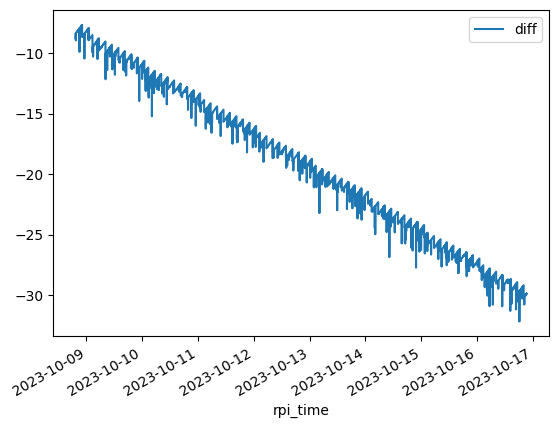

In [11]:
#%matplotlib widget
reduced.plot(x="rpi_time", y="diff")
if "diff_millis" in reduced:
    reduced.plot(x="rpi_time", y="diff millis")